# Project Description

The task is to forecast the gold recovery coefficient from ore containing gold, utilizing data on both mining and refining parameters.

## Data Upload and Overview

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer

In [ ]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [ ]:
df_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')
df_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
df_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')

In [ ]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

In [ ]:
print('df_full', df_full.shape)
print('df_train', df_train.shape)
print('df_test', df_test.shape)

df_full (19439, 87)
df_train (14149, 87)
df_test (5290, 53)


Conclusion: 34 features are missing in the test dataset.

### Checking the accuracy of the enrichment efficiency calculation

- C: The percentage of gold in the concentrate after flotation/cleaning; referred to as "final.output.concentrate_au".
- F: The percentage of gold in the raw material/concentrate before flotation/cleaning; referred to as "rougher.input.feed_au".
- T: The percentage of gold in the tailings after flotation/cleaning; referred to as "final.output.tail_au".

The formula for calculating recovery is: Recovery = 100 * C * (F-T) / (F * (C-T)).

In [ ]:
C = df_train['rougher.output.concentrate_au']
F = df_train['rougher.input.feed_au']
T = df_train['rougher.output.tail_au']

In [ ]:
recovery = 100*(C*(F - T))/(F*(C - T))

In [ ]:
mae = mean_absolute_error(df_train['rougher.output.recovery'], recovery)

In [ ]:
mae

1.1131451184435918e-14

Conclusion: While there was a minor error, the calculation of the enrichment efficiency is accurate.

### Features that are not present in the test dataset

In [ ]:
absent_columns = list(set(df_full.columns) - set(df_test.columns))

In [ ]:
absent_columns.sort()
absent_columns

['final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

In [ ]:
df_full[df_full.columns.intersection(absent_columns)].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 34 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         19438 non-null  float64
 1   final.output.concentrate_pb                         19438 non-null  float64
 2   final.output.concentrate_sol                        19228 non-null  float64
 3   final.output.concentrate_au                         19439 non-null  float64
 4   final.output.recovery                               19439 non-null  float64
 5   final.output.tail_ag                                19438 non-null  float64
 6   final.output.tail_pb                                19338 non-null  float64
 7   final.output.tail_sol                               19433 non-null  float64
 8   final.output.tail_au                                19439 non-null  float64


Based on the available information, it can be inferred that the test dataset does not contain the target variables final.output.recovery and rougher.output.recovery.

### Data Preprocessing

In [ ]:
# The practice of filling in missing values with previous data points
# is justifiable since features change insignificantly over time.

df_train = df_train.ffill()
df_test = df_test.ffill()
df_full = df_full.ffill()

In [ ]:
# Adding target features to the test dataset

df_test = df_test.merge(df_full[['date', 'final.output.recovery', 'rougher.output.recovery']], on = 'date')

In [ ]:
df_test.shape

(5290, 55)

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5290 entries, 0 to 5289
Data columns (total 55 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5290 non-null   float64
 2   primary_cleaner.input.depressant            5290 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5290 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

The target features have been incorporated into the test dataset and the datasets are now ready for model development.

## Data Analysis
### Analysis of changes in the concentration of metals (Au, Ag, Pb) at different stages

In [ ]:
metal_au = df_full[["rougher.input.feed_au", "rougher.output.concentrate_au", "primary_cleaner.output.concentrate_au", "final.output.concentrate_au"]]
metal_ag = df_full[["rougher.input.feed_ag", "rougher.output.concentrate_ag", "primary_cleaner.output.concentrate_ag", "final.output.concentrate_ag"]]
metal_pb = df_full[["rougher.input.feed_pb", "rougher.output.concentrate_pb", "primary_cleaner.output.concentrate_pb", "final.output.concentrate_pb"]]

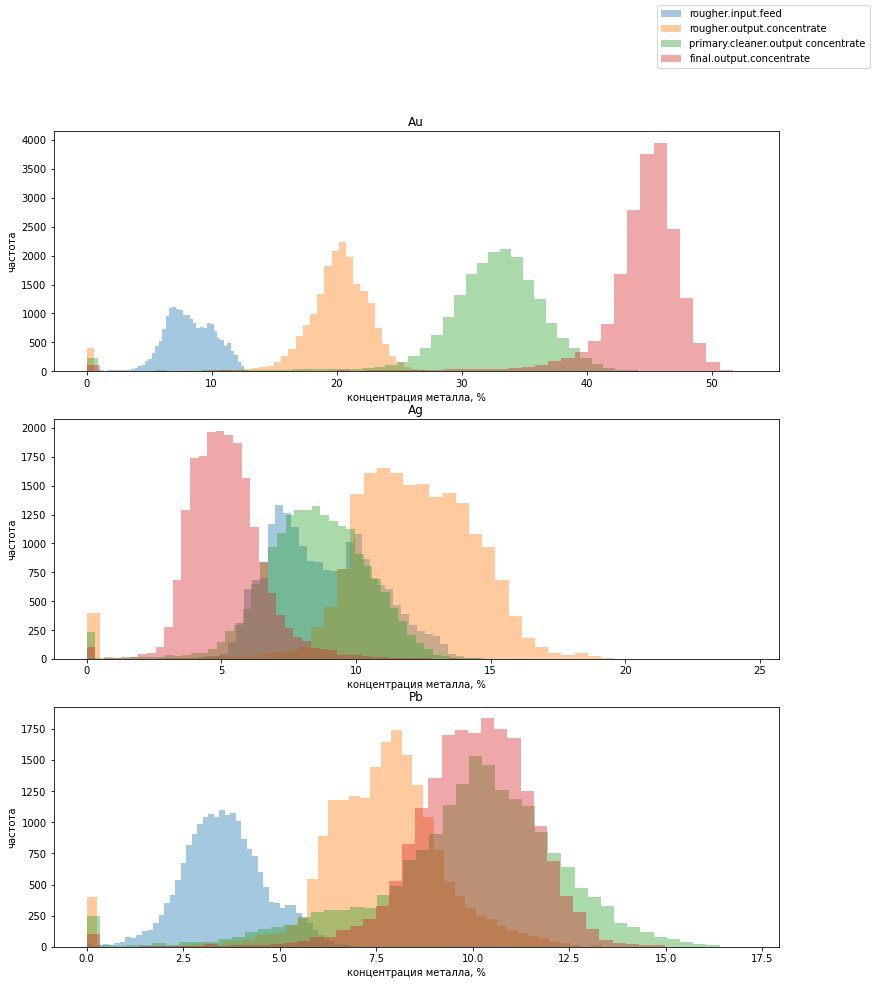

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(13, 15));

for column in list(metal_au):
    sns.distplot(metal_au[column], ax=axes[0], kde=False)
axes[0].set(title="Au", xlabel="концентрация металла, %", ylabel="частота")
for column in list(metal_ag):
    sns.distplot(metal_ag[column], ax=axes[1], kde=False)
axes[1].set(title="Ag", xlabel="концентрация металла, %", ylabel="частота")
for column in list(metal_pb):
    sns.distplot(metal_pb[column], ax=axes[2], kde=False)
axes[2].set(title="Pb", xlabel="концентрация металла, %", ylabel="частота")

fig.legend(["rougher.input.feed", "rougher.output.concentrate", "primary.cleaner.output concentrate", "final.output.concentrate",])
fig.show()

Conclusions:

- The concentration of Au increases after each stage, which is logical since the process is focused on gold;
- The concentration of Ag increases after enrichment, but then decreases to values lower than the initial ones;
- The concentration of Pb increases during enrichment and purification, and after the second purification stage, the distribution narrows with an unchanged mode.

### Comparison of the size of raw material particles in the training and testing datasets

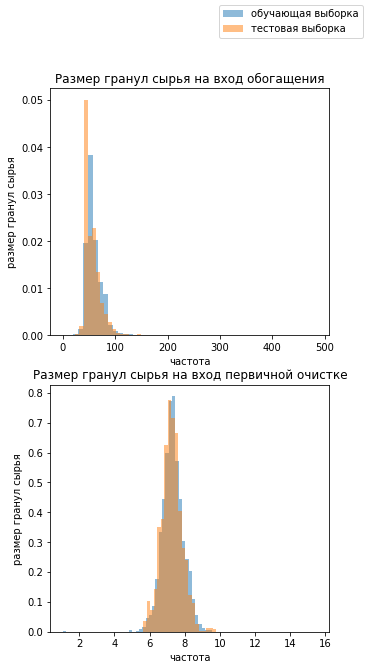

In [ ]:
fig, axes = plt.subplots(2,1, figsize=(5, 10))

axes[0].hist(df_train["rougher.input.feed_size"], density=True, alpha=0.5, bins=50)
axes[0].hist(df_test["rougher.input.feed_size"], density=True, alpha=0.5, bins=50)
axes[0].set(title="Размер гранул сырья на вход обогащения", xlabel="частота", ylabel="размер гранул сырья")

axes[1].hist(df_train["primary_cleaner.input.feed_size"], density=True, alpha=0.5, bins=50)
axes[1].hist(df_test["primary_cleaner.input.feed_size"], density=True, alpha=0.5, bins=50)
axes[1].set(title="Размер гранул сырья на вход первичной очистке", xlabel="частота", ylabel="размер гранул сырья")

fig.legend(["обучающая выборка", "тестовая выборка"])
fig.show()

Based on the granule sizes in the training and testing datasets being similar, we can conclude that these data can be utilized for model creation

### Study of the overall concentration of metals at different stages

In [ ]:
rougher_input = df_full["rougher.input.feed_au"] + df_full["rougher.input.feed_ag"] + df_full["rougher.input.feed_pb"] + df_full["rougher.input.feed_sol"]
rougher_output = df_full["rougher.output.concentrate_au"] + df_full["rougher.output.concentrate_ag"] + df_full["rougher.output.concentrate_pb"] + df_full["rougher.output.concentrate_sol"]
final_output = df_full["final.output.concentrate_au"] + df_full["final.output.concentrate_ag"] + df_full["final.output.concentrate_pb"] + df_full["final.output.concentrate_sol"]

metal_concentrations = pd.DataFrame({'rougher_input':rougher_input, 'rougher_output':rougher_output, 'final_output':final_output})

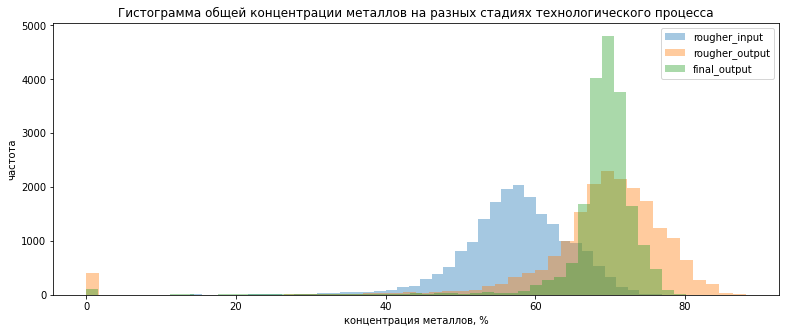

In [ ]:
fig = plt.figure(figsize=(13, 5))

for column in list(metal_concentrations):
    sns.distplot(metal_concentrations[column], kde=False)

plt.legend(list(metal_concentrations))
plt.title("Гистограмма общей концентрации металлов на разных стадиях технологического процесса")
plt.xlabel("концентрация металлов, %")
plt.ylabel("частота")
fig.show()

In conclusion, the concentration of metals increases significantly after the enrichment process and becomes more concentrated towards the end of the technological process, resulting in a narrower distribution

In [ ]:
date_rougher = df_full[rougher_input < 0.5]['date']
df_train = df_train.query('date not in @date_rougher')

date_rougher = df_full[rougher_output < 0.5]['date']
df_train = df_train.query('date not in @date_rougher')

date_rougher = df_full[df_full["primary_cleaner.output.concentrate_au"] < 0.5]['date']
df_train = df_train.query('date not in @date_rougher')

date_rougher = df_full[df_full["primary_cleaner.output.concentrate_ag"] < 0.5]['date']
df_train = df_train.query('date not in @date_rougher')

date_rougher = df_full[df_full["primary_cleaner.output.concentrate_pb"] < 0.5]['date']
df_train = df_train.query('date not in @date_rougher')

date_rougher = df_full[final_output < 0.5]['date']
df_train = df_train.query('date not in @date_rougher')

In [ ]:
rougher_input = df_train["rougher.input.feed_au"] + df_train["rougher.input.feed_ag"] + df_train["rougher.input.feed_pb"] + df_train["rougher.input.feed_sol"]
rougher_output = df_train["rougher.output.concentrate_au"] + df_train["rougher.output.concentrate_ag"] + df_train["rougher.output.concentrate_pb"] + df_train["rougher.output.concentrate_sol"]
final_output = df_train["final.output.concentrate_au"] + df_train["final.output.concentrate_ag"] + df_train["final.output.concentrate_pb"] + df_train["final.output.concentrate_sol"]

metal_concentrations = pd.DataFrame({'rougher_input':rougher_input, 'rougher_output':rougher_output, 'final_output':final_output})

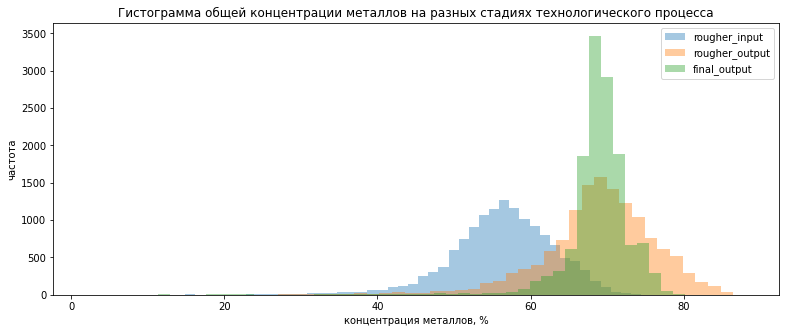

In [ ]:
fig = plt.figure(figsize=(13, 5))

for column in list(metal_concentrations):
    sns.distplot(metal_concentrations[column], kde=False)

plt.legend(list(metal_concentrations))
plt.title("Гистограмма общей концентрации металлов на разных стадиях технологического процесса")
plt.xlabel("концентрация металлов, %")
plt.ylabel("частота")
fig.show()

In [ ]:
metal_au = df_train[["rougher.input.feed_au", "rougher.output.concentrate_au", "primary_cleaner.output.concentrate_au", "final.output.concentrate_au"]]
metal_ag = df_train[["rougher.input.feed_ag", "rougher.output.concentrate_ag", "primary_cleaner.output.concentrate_ag", "final.output.concentrate_ag"]]
metal_pb = df_train[["rougher.input.feed_pb", "rougher.output.concentrate_pb", "primary_cleaner.output.concentrate_pb", "final.output.concentrate_pb"]]

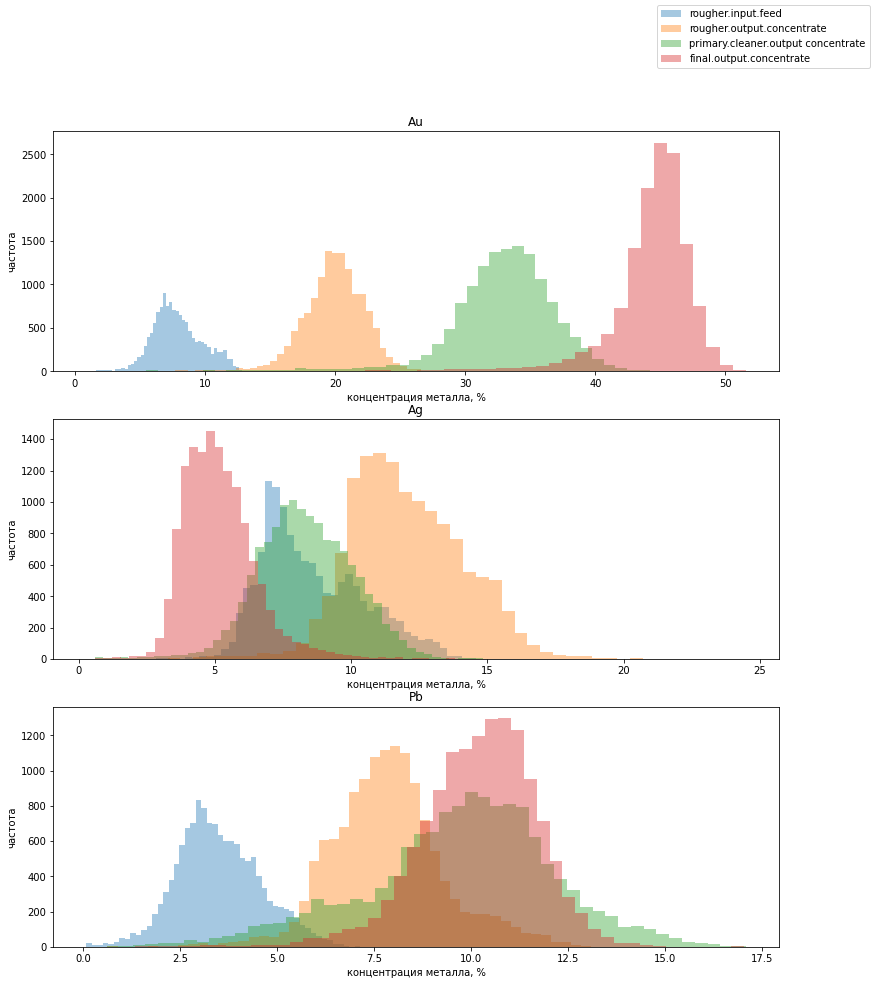

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(13, 15));

for column in list(metal_au):
    sns.distplot(metal_au[column], ax=axes[0], kde=False)
axes[0].set(title="Au", xlabel="концентрация металла, %", ylabel="частота")
for column in list(metal_ag):
    sns.distplot(metal_ag[column], ax=axes[1], kde=False)
axes[1].set(title="Ag", xlabel="концентрация металла, %", ylabel="частота")
for column in list(metal_pb):
    sns.distplot(metal_pb[column], ax=axes[2], kde=False)
axes[2].set(title="Pb", xlabel="концентрация металла, %", ylabel="частота")

fig.legend(["rougher.input.feed", "rougher.output.concentrate", "primary.cleaner.output concentrate", "final.output.concentrate",])
fig.show()

In [ ]:
# In this case, we will remove the date as it is unlikely to have an impact on the quality of production

df_train = df_train.drop("date", axis=1)
df_test = df_test.drop("date", axis=1)
df_full = df_full.drop("date", axis=1)

## Model

There are two possible approaches to consider when building the model: creating individual models for each of the target features or building a single model that accounts for both features simultaneously. The decision was made to pursue the first approach due to time constraints, although it may be less sophisticated than the latter.

### Function of final sMAPE score

In [ ]:
def fsmape(target_actual, target_predictions):
    numerator = np.abs(target_actual - target_predictions)
    denominator = (np.abs(target_actual) + np.abs(target_predictions)) / 2 
    return abs(1 / len(target_actual) * np.sum(numerator / denominator) * 100)

In [ ]:
def fsmape_final(target_rougher, prediction_rougher, target_final, prediction_final):
    smape_final = 0.25*fsmape(target_rougher, prediction_rougher) + 0.75*fsmape(target_final, prediction_final)
    return abs(smape_final)

In [ ]:
# The statement pertains to creating metrics from a function. As metrics reflect errors,
# it is crucial that they decrease over time. Therefore, it is necessary to specify
# greater_is_better=False to indicate this.

smape_scorer = make_scorer(fsmape, greater_is_better = False) 
smape_final_scorer = make_scorer(fsmape_final, greater_is_better = False)

### Model Training

#### Linear Regression

In [ ]:
# To improve the clarity and precision of the translation, I suggest the following revision:

target_train_rougher = df_train['rougher.output.recovery']
target_train_final = df_train['final.output.recovery']

features_train = df_train.drop(df_train.columns.difference(df_test.columns), axis = 1)
features_train = features_train.drop(['rougher.output.recovery', 'final.output.recovery'], axis = 1)

target_test_rougher = df_test['rougher.output.recovery']
target_test_final = df_test['final.output.recovery']

features_test = df_test.drop(['rougher.output.recovery', 'final.output.recovery'], axis = 1)

print('target_train_rougher', target_train_rougher.shape)
print('target_train_final', target_train_final.shape)
print('features_train', features_train.shape)

print('target_test_rougher', target_test_rougher.shape)
print('target_test_final', target_test_final.shape)
print('features_test', features_test.shape)

target_train_rougher (13581,)
target_train_final (13581,)
features_train (13581, 52)
target_test_rougher (5290,)
target_test_final (5290,)
features_test (5290, 52)


In [ ]:
# While scaling is not mandatory, some code reviewers may require it based on feedback
# from fellow students. It's worth considering the potential benefits of scaling in terms
# of performance, efficiency, and future maintenance, but ultimately it's up to the project's
# specific requirements and constraints.

scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)

features_test = scaler.transform(features_test)

print(features_train.shape)
print(features_test.shape)

(13581, 52)
(5290, 52)


In [ ]:
# Performing cross-validation of linear regression on the training set to predict the
# effectiveness of rougher concentrate enrichment

lr_model_rougher = LinearRegression()
scores_rougher = cross_val_score(lr_model_rougher, features_train, target_train_rougher, cv=5, scoring = smape_scorer)
lr_score_rougher = abs(sum(scores_rougher) / len(scores_rougher))
print('Средняя оценка качества модели линейной регрессии sMAPE для lr_model_rougher:', lr_score_rougher)

Средняя оценка качества модели линейной регрессии sMAPE для lr_model_rougher: 7.283471347429938


In [ ]:
# Cross-validation of a linear regression model on the training set to
# predict the efficiency of final concentrate enrichment.

lr_model_final = LinearRegression()
scores_final = cross_val_score(lr_model_final, features_train, target_train_final, cv=5, scoring = smape_scorer)
lr_score_final = abs(sum(scores_final) / len(scores_final))
print('Средняя оценка качества модели линейной регрессии sMAPE для lr_model_final:', lr_score_final)

Средняя оценка качества модели линейной регрессии sMAPE для lr_model_final: 11.007780402962796


In [ ]:
print("Средняя взвешенная оценка качества модели линейной регрессии sMAPE:", 0.25*lr_score_rougher+0.75*lr_score_final)

Средняя взвешенная оценка качества модели линейной регрессии sMAPE: 10.076703139079582


#### Decision Tree Regression

In [ ]:
%%time

dt_model_rougher = DecisionTreeRegressor(random_state=12345)

parameters = {'max_depth': range(1,6),
             'min_samples_leaf': range(1,6),
             'min_samples_split': range(2,10,2)}

grid_rougher = GridSearchCV(dt_model_rougher, parameters, scoring=smape_scorer, cv = 5, n_jobs = -1)
grid_rougher.fit(features_train, target_train_rougher)

print('best_score:%f'%abs(grid_rougher.best_score_))
print('best_parameters:', grid_rougher.best_params_)

best_score:6.736126
best_parameters: {'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 2}
CPU times: user 1min 59s, sys: 0 ns, total: 1min 59s
Wall time: 2min 2s


In [ ]:
%%time

dt_model_final = DecisionTreeRegressor(random_state=12345)

parameters = {'max_depth': range(1,6),
             'min_samples_leaf': range(1,6),
             'min_samples_split': range(2,10,2)}

grid_final = GridSearchCV(dt_model_final, parameters, scoring=smape_scorer, cv = 5, n_jobs = -1)
grid_final.fit(features_train, target_train_final)

print('best_score:%f'%abs(grid_final.best_score_))
print('best_parameters:', grid_final.best_params_)

best_score:9.215108
best_parameters: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
CPU times: user 2min 2s, sys: 0 ns, total: 2min 2s
Wall time: 2min 2s


In [ ]:
print("Средняя взвешенная оценка качества модели дерева решений sMAPE:", 0.25*abs(grid_rougher.best_score_)+0.75*abs(grid_final.best_score_))

Средняя взвешенная оценка качества модели дерева решений sMAPE: 8.595362556306714


The metric is lower, indicating superior performance compared to linear regression.

#### Random Forest Regression

In [ ]:
%%time

rf_model_rougher = RandomForestRegressor(random_state=12345)

parameters = {'n_estimators': range(50,101,25),
             'max_depth': range(4,8,1)}


grid_rougher = GridSearchCV(rf_model_rougher, parameters, scoring=smape_scorer, cv = 5, n_jobs = -1)
grid_rougher.fit(features_train, target_train_rougher)

print('best_score:%f'%abs(grid_rougher.best_score_))
print('best_parameters:', grid_rougher.best_params_)

best_score:6.329979
best_parameters: {'max_depth': 6, 'n_estimators': 100}
CPU times: user 18min 21s, sys: 281 ms, total: 18min 22s
Wall time: 18min 37s


In [ ]:
%%time

rf_model_final = RandomForestRegressor(random_state=12345)

parameters = {'n_estimators': range(50,101,25),
             'max_depth': range(4,8,1)}


grid_final = GridSearchCV(rf_model_final, parameters, scoring=smape_scorer, cv = 5, n_jobs = -1)
grid_final.fit(features_train, target_train_final)

print('best_score:%f'%abs(grid_final.best_score_))
print('best_parameters:', grid_final.best_params_)

best_score:8.916202
best_parameters: {'max_depth': 4, 'n_estimators': 50}
CPU times: user 18min 51s, sys: 344 ms, total: 18min 51s
Wall time: 18min 54s


In [ ]:
print("Средняя взвешенная оценка качества модели случайного леса sMAPE:", 0.25*abs(grid_rougher.best_score_)+0.75*abs(grid_final.best_score_))

Средняя взвешенная оценка качества модели случайного леса sMAPE: 8.269646268743637


Conclusion: The random forest model has the lowest sMAPE metric, making it the best performing model.

#### Checking on a test sample

In [ ]:
rf_model_rougher = RandomForestRegressor(n_estimators = 100, max_depth = 6, random_state=12345)

rf_model_rougher.fit(features_train, target_train_rougher)

predictions_test_rougher = rf_model_rougher.predict(features_test)

In [ ]:
score_rougher = fsmape(target_test_rougher, predictions_test_rougher)
print('sMAPE:', score_rougher)

sMAPE: 7.970580900980516


In [ ]:
rf_model_final = RandomForestRegressor(n_estimators = 50, max_depth = 4, random_state=12345)

rf_model_final.fit(features_train, target_train_final)

predictions_test_final = rf_model_final.predict(features_test)

In [ ]:
score_final = fsmape(target_test_final, predictions_test_final)
print('sMAPE:', score_final)

sMAPE: 9.722031623038278


In [ ]:
print("final sMAPE = ", 0.25*score_rougher+0.75*score_final)

final sMAPE =  9.274582826585709


In [ ]:
# dummy-model

predicted_test_rougher_mean = pd.Series(target_train_rougher.mean(), index = target_test_rougher.index)
predicted_test_final_mean = pd.Series(target_train_final.mean(), index = target_test_final.index)

score_rougher = fsmape(target_test_rougher, predicted_test_rougher_mean)
score_final = fsmape(target_test_final, predicted_test_final_mean)

print("final dummy sMAPE = ", 0.25*score_rougher+0.75*score_final)

final dummy sMAPE =  9.827647160711791


Conclusion: Based on the statistical analysis, the random forest model outperformed the constant dummy model and was deemed the most effective. This was confirmed by the adequacy test, which showed that the random forest model had a lower sMAPE error compared to the dummy model.